## Stock Movement Prediction using Reddit Data

The sources provide a detailed walkthrough of a project that uses Reddit data to predict stock movements. Here is a summary of the key steps and insights:

**1. Data Collection:**

* The project focuses on collecting data from three subreddits: 'wallstreetbets', 'stocks', and 'investing', which are known for their active discussions on stocks and investments.
* Using the `asyncpraw` library, an asynchronous function is defined to efficiently collect data from these subreddits. This allows the program to simultaneously fetch data from multiple sources without waiting for each request to complete.
* For each post, the function gathers information such as the subreddit name, post title, score, URL, number of comments, and creation timestamp. 

**2. Data Cleaning:**

* Before analysis, the collected data needs to be cleaned. This involves:
    * **Handling missing values:** Rows with missing data are removed to avoid errors in analysis.
    * **Removing emojis and special characters:** These can interfere with sentiment analysis and are therefore removed using regular expressions. 
    * **Removing duplicate entries:** This ensures that each post is only analysed once.
    * **Converting timestamps to datetime format:** This allows for easier manipulation and analysis of time-related trends. 

**3. Sentiment Analysis:**

* Sentiment analysis is performed using the `vaderSentiment` library, which assigns a sentiment score to each post title.
* The compound score, ranging from -1 (most negative) to +1 (most positive), is used to represent the overall sentiment of a post.
* Sentiment scores are further categorised into positive, negative, and neutral labels using adjusted thresholds for more straightforward interpretation.
* The results of the sentiment analysis are saved to a separate CSV file for future use.

**4. Feature Extraction:**

* Besides sentiment polarity, the project extracts additional features relevant to stock movement prediction:
    * **Frequency of stock mentions:** The number of times specific stock symbols (like AAPL, TSLA, GME) are mentioned in post titles is counted using regular expressions. This serves as a measure of investor interest and potential stock volatility.
    * **Sentiment polarity by stock:** While not explicitly mentioned in the sources, the provided code can be easily adapted to calculate the average sentiment polarity for posts mentioning specific stocks. This could provide insights into how sentiment towards specific companies might influence their stock prices.

**5. Topic Modelling:**

* Latent Dirichlet Allocation (LDA), a statistical method for topic extraction, is applied to the post titles to identify the main themes being discussed.
* The `CountVectorizer` is used to convert the text data into a numerical format suitable for LDA.
* LDA identifies five distinct topics from the data, revealing conversations around market trends, specific stocks, and influential figures like Elon Musk.

**6. Correlation Analysis:**

* Historical stock price data is fetched using the `yfinance` library for the selected stock symbols.
* The stock data is merged with the Reddit data based on the date of the posts. This allows for the analysis of relationships between sentiment, mentions, and stock price changes.
* Correlations are calculated between sentiment polarity, stock mentions, and stock prices to assess potential relationships.
* The results, while not explicitly shown in the sources, can provide insights into whether positive or negative sentiment, or the frequency of mentions, is correlated with changes in stock prices.

**7. Visualisation:**

* Data visualisation is implemented using libraries like `matplotlib` and `seaborn` to better understand the trends and relationships within the data. 
* Line plots are used to visualise the average daily sentiment polarity over time, allowing for the observation of overall sentiment trends. 
* Separate line plots visualise the frequency of mentions for specific stocks over time, highlighting periods of increased investor attention. 
* Stock price changes over time are also plotted to observe price fluctuations. 
* A scatter plot is used to explore the relationship between sentiment polarity and price changes for a specific stock (AAPL in this case). 
* A heatmap visually represents the correlations between sentiment polarity and price changes for multiple stocks, offering a comprehensive overview of the relationships.

**8. Insights and Recommendations:**

* The sources highlight that stocks like GME and AMC, often categorized as "meme stocks," exhibit high sensitivity to social media sentiment. Positive sentiment on platforms like Reddit can potentially lead to short-term price increases, while negative sentiment may signal price drops. 
* Tesla (TSLA) also displays some sensitivity to sentiment, although not as pronounced as GME and AMC. It's recommended to use sentiment analysis alongside other indicators for a more comprehensive view.
* Apple (AAPL), being a more established company, shows low sensitivity to social media sentiment.  Investment decisions for such companies should be primarily based on fundamental analysis rather than sentiment trends.

**9. Future Expansions:**

* The sources propose several avenues for enhancing the project's analysis and prediction accuracy:
    * **Incorporate multiple data sources:** Integrating news articles, financial reports, analyst ratings, and economic data can provide a more holistic understanding of factors influencing stock prices.
    * **Adopt advanced sentiment analysis models:** Utilising NLP models like BERT or GPT can improve sentiment analysis accuracy by better capturing nuanced language and context.
    * **Implement real-time sentiment tracking:** This allows for timely responses to emerging trends and market events.
    * **Integrate volume and volatility metrics:** Including trading volume and stock volatility data can provide a clearer picture of how sentiment and attention translate into price movements. 
    * **Expand sector-level analysis:** Analysing sentiment across entire sectors can help identify broader trends affecting multiple stocks and industries.

**10. Conclusion:**

The project demonstrated in the sources effectively showcases the potential of using Reddit data for stock movement prediction, particularly for volatile stocks heavily influenced by social media sentiment. However, it's essential to remember that sentiment analysis should be used as one of many tools in making informed investment decisions. Further enhancements, as suggested in the sources, can improve the accuracy and scope of these predictions, leading to more robust and valuable insights. 


# CODE AND VISUALIZATION

In [4]:
pip install praw vaderSentiment

In [7]:
pip install asyncpraw

   ---------------------------------------- 0.0/196.4 kB ? eta -:--:--
   ------ --------------------------------- 30.7/196.4 kB 1.3 MB/s eta 0:00:01
   ---------------- ----------------------- 81.9/196.4 kB 1.5 MB/s eta 0:00:01
   ---------------------- ----------------- 112.6/196.4 kB 1.3 MB/s eta 0:00:01
   --------------------------------- ------ 163.8/196.4 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- 196.4/196.4 kB 990.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 1. DATA COLLECTING

In [9]:

import asyncpraw
import pandas as pd
import nest_asyncio  # For Jupyter environments
import asyncio

# Apply nest_asyncio to handle nested event loops (for interactive environments like Jupyter)
nest_asyncio.apply()

# Function to collect Reddit posts asynchronously for a single subreddit
async def fetch_subreddit_data(subreddit_name, reddit, limit=5000):
    print(f"Fetching data from: {subreddit_name}")
    subreddit = await reddit.subreddit(subreddit_name)

    # Create a list to store the data for each subreddit
    posts_data = []

    # Fetch the top posts asynchronously
    async for post in subreddit.top(limit=limit):  # Adjust the limit as needed
        posts_data.append({
            'Subreddit': subreddit_name,
            'Title': post.title,
            'Score': post.score,
            'URL': post.url,
            'Comments': post.num_comments,
            'Created': post.created_utc
        })

    # Convert the list to a DataFrame
    df = pd.DataFrame(posts_data)

    # Save the DataFrame to a CSV file for each subreddit
    filename = f'reddit_{subreddit_name}_data.csv'
    df.to_csv(filename, index=False)
    print(f"Data has been saved to {filename}")

# Function to handle multiple subreddits concurrently
async def fetch_multiple_subreddits(subreddits, limit=5000):
    # Initialize the Reddit instance
    reddit = asyncpraw.Reddit(
        client_id="VxLbug0nGeWtD0FeWt4Vrw",
        client_secret="2C79j2B50VgrVLhM63CD8IP7TIE8Tg",
        user_agent="livindevil"
    )

    # Use asyncio.gather to fetch multiple subreddits concurrently
    tasks = [fetch_subreddit_data(subreddit, reddit, limit) for subreddit in subreddits]
    await asyncio.gather(*tasks)

    print("Data collection completed.")

# List of subreddits to collect data from
subreddits_to_collect = ['wallstreetbets', 'stocks', 'investing']

# In an interactive environment (like Jupyter), use 'await' to call the async function
await fetch_multiple_subreddits(subreddits=subreddits_to_collect, limit=5000)


Fetching data from: wallstreetbets
Fetching data from: stocks
Fetching data from: investing
Data has been saved to reddit_wallstreetbets_data.csv
Data has been saved to reddit_investing_data.csv
Data has been saved to reddit_stocks_data.csv
Data collection completed.


## 2. DATA CLEANING

In [18]:
import pandas as pd
import re
import os

# Function to clean each DataFrame
def clean_reddit_data(df):
    # Handle missing values
    df.dropna(inplace=True)  # Drop rows with any missing values

    # Remove emojis and special symbols from the 'Title' column
    def remove_emoji_and_special_symbols(text):
        # Remove emojis
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove special symbols, but keep basic punctuation
        text = re.sub(r'[^a-zA-Z0-9\s,.?!]', '', text)
        return text

    df['Title'] = df['Title'].apply(remove_emoji_and_special_symbols)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Convert 'Created' column to datetime
    df['Created'] = pd.to_datetime(df['Created'], unit='s')

    return df

# List of CSV files to clean and merge
csv_files = ['reddit_wallstreetbets_data.csv', 'reddit_stocks_data.csv', 'reddit_investing_data.csv']

# List to store the cleaned DataFrames
cleaned_dataframes = []

# Iterate over the list of files, load, clean, and store the DataFrames
for file in csv_files:
    if os.path.exists(file):
        # Load the data
        df = pd.read_csv(file)

        # Clean the data
        df_cleaned = clean_reddit_data(df)

        # Check if DataFrame is empty after cleaning
        if not df_cleaned.empty:
            # Add the cleaned DataFrame to the list
            cleaned_dataframes.append(df_cleaned)
        else:
            print(f"DataFrame from {file} is empty after cleaning.")
    else:
        print(f"File {file} does not exist.")

# Combine all cleaned DataFrames into one
if cleaned_dataframes:
    combined_df = pd.concat(cleaned_dataframes, ignore_index=True)

    # Save the combined cleaned DataFrame to a new CSV file
    combined_df.to_csv('combined_cleaned_reddit_data.csv', index=False)

    print("All data has been cleaned and combined into combined_cleaned_reddit_data.csv")
else:
    print("No data to combine after cleaning.")


All data has been cleaned and combined into combined_cleaned_reddit_data.csv


## 3. SENTIMENT ANALYSIS

In [22]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the cleaned and combined data from multiple subreddits
df = pd.read_csv('combined_cleaned_reddit_data.csv')

# Drop rows where 'Title' is NaN
df = df.dropna(subset=['Title'])

# Ensure 'Title' column is of type string
df['Title'] = df['Title'].astype(str)

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment polarity for each text
def get_sentiment(text):
    try:
        sentiment = analyzer.polarity_scores(text)
        return sentiment['compound']  # Return the compound score (-1 to +1)
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        return None

# Apply the sentiment analysis function to each title
df['Sentiment'] = df['Title'].apply(get_sentiment)

# Check for any None values in the Sentiment column (in case some texts couldn't be analyzed)
if df['Sentiment'].isnull().any():
    print("There are some rows with None values in the Sentiment column. Dropping these rows.")
    df.dropna(subset=['Sentiment'], inplace=True)

# Classify the sentiment as positive, negative, or neutral based on the compound score with adjusted thresholds
df['Sentiment_Label'] = df['Sentiment'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)

# Save the dataset with the sentiment labels
df.to_csv('reddit_sentiment_analysis.csv', index=False)

print("Sentiment analysis completed and saved to 'reddit_sentiment_analysis.csv'.")

Sentiment analysis completed and saved to 'reddit_sentiment_analysis.csv'.


### 3.1 SENTIMENT ANALYSIS REPORT

In [33]:
# Display the first few rows of the DataFrame to see the sentiment analysis
print(df.head())
print("\n")

# Display specific columns (Title, Sentiment, and Sentiment_Label)
print(df[['Title', 'Sentiment', 'Sentiment_Label']].head(10))  # Print the first 10 rows
print("\n")

# Count the number of posts for each sentiment label
sentiment_counts = df['Sentiment_Label'].value_counts()
print("Sentiment Label Distribution:")
print(sentiment_counts)
print("\n")

# Display summary statistics for sentiment scores
print("Sentiment Score Statistics:")
print("\n")
print(df['Sentiment'].describe())

        Subreddit                                   Title   Score  \
0  wallstreetbets                  Times Square right now  489213   
1  wallstreetbets  UPVOTE so everyone sees we got SUPPORT  338563   
2  wallstreetbets            GME YOLO update  Jan 28 2021  300887   
3  wallstreetbets      GME YOLO monthend update  Jan 2021  264908   
4  wallstreetbets                        Its treason then  247651   

                                   URL  Comments              Created  \
0      https://v.redd.it/x64z70f7eie61     14015  2021-01-30 18:00:38   
1  https://i.redd.it/sgoqy8nyt2e61.png     12843  2021-01-28 13:40:34   
2  https://i.redd.it/opzucppb15e61.png     23006  2021-01-28 21:06:23   
3  https://i.redd.it/r557em3t5ce61.png     19895  2021-01-29 21:04:45   
4  https://i.redd.it/d3t66lv1yce61.jpg      4596  2021-01-29 23:40:59   

   Sentiment Sentiment_Label  
0     0.0000         neutral  
1     0.5319        positive  
2     0.4278        positive  
3     0.4278        po

### 3.2 FREQUENCY OF MENTIONS

In [40]:
import pandas as pd
import re

# Load the combined cleaned data from multiple subreddits
df = pd.read_csv('combined_cleaned_reddit_data.csv')

# Ensure 'Title' column is of type string for processing
df['Title'] = df['Title'].astype(str)

# Define a list of stock symbols you're interested in tracking
stock_symbols = ['AAPL', 'TSLA', 'GME', 'AMC', 'NVDA', 'SPCE', 'PLTR', 'LCID', 'SOFI', 'AMD', 'PTON', 'TLRY', 'IRNTQ']

# Create columns for each stock symbol to track mentions
for symbol in stock_symbols:
    try:
        # Use regex to count mentions of each stock symbol as a standalone word (ignores case)
        regex = r'\b' + re.escape(symbol) + r'\b'  # Create a regex pattern with word boundaries
        df[symbol + '_Mentions'] = df['Title'].apply(lambda x: 1 if re.search(regex, x.upper()) else 0)
    except TypeError as e:
        print(f"Error processing symbol: {symbol}")
        print(e)

# Save the updated DataFrame with stock mention counts
df.to_csv('combined_cleaned_with_mentions_reddit_data.csv', index=False)

print("Feature extraction for stock mentions completed.")

Feature extraction for stock mentions completed.


In [43]:
# Total mentions for each stock
for symbol in stock_symbols:
    print(f"Total mentions for {symbol}: {df[symbol + '_Mentions'].sum()}")

# Print the first few rows to check the stock mention columns
print(df[['Title'] + [symbol + '_Mentions' for symbol in stock_symbols]].head(10))

Total mentions for AAPL: 5
Total mentions for TSLA: 26
Total mentions for GME: 164
Total mentions for AMC: 29
Total mentions for NVDA: 4
Total mentions for SPCE: 2
Total mentions for PLTR: 11
Total mentions for LCID: 0
Total mentions for SOFI: 1
Total mentions for AMD: 8
Total mentions for PTON: 1
Total mentions for TLRY: 0
Total mentions for IRNTQ: 0
                                               Title  AAPL_Mentions  \
0                             Times Square right now              0   
1             UPVOTE so everyone sees we got SUPPORT              0   
2                       GME YOLO update  Jan 28 2021              0   
3                 GME YOLO monthend update  Jan 2021              0   
4                                   Its treason then              0   
5  CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...              0   
6                       GME YOLO update  Feb 19 2021              0   
7  GME YOLO update  Jan 27 2021  guess i need 102...              0   
8      

### 3.3 Feature extraction for sentiment polarity

In [47]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Load the combined cleaned data from multiple subreddits
df = pd.read_csv('combined_cleaned_reddit_data.csv')

# Ensure 'Title' column is of type string for further processing
df['Title'] = df['Title'].astype(str)

# Step 1: Perform Sentiment Analysis

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    try:
        sentiment = analyzer.polarity_scores(text)
        return sentiment['compound']  # Use the compound score
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        return None

# Apply sentiment analysis to the 'Title' column
df['Sentiment'] = df['Title'].apply(get_sentiment)

# Handle any None values in the Sentiment column
df.dropna(subset=['Sentiment'], inplace=True)

# Extract Sentiment Polarity (using the 'Sentiment' column)
df['Sentiment_Polarity'] = df['Sentiment']  # Copy the sentiment polarity into a new column

# Step 2: Extract Frequency of Mentions for Specific Stocks

# Define a list of stock symbols you're interested in tracking
stock_symbols = ['AAPL', 'TSLA', 'GME', 'AMC', 'NVDA', 'SPCE', 'PLTR', 'LCID', 'SOFI', 'AMD', 'PTON', 'TLRY', 'IRNTQ']

# Create columns for each stock symbol to track mentions
for symbol in stock_symbols:
    try:
        # Use regex to count mentions of each stock symbol as a standalone word (ignores case)
        regex = r'\b' + re.escape(symbol) + r'\b'  # Word boundaries to ensure standalone match
        df[symbol + '_Mentions'] = df['Title'].apply(lambda x: 1 if re.search(regex, x.upper()) else 0)
    except TypeError as e:
        print(f"Error processing symbol: {symbol}")
        print(e)

# Step 3: Save the DataFrame with extracted features

# Save the updated DataFrame with sentiment polarity and stock mention counts
df.to_csv('combined_cleaned_with_features_reddit_data.csv', index=False)

print("Feature extraction for sentiment polarity and stock mentions completed.")

# Step 4: Print Key Features and Total Mentions

# Print some key features
print(df[['Title', 'Sentiment_Polarity'] + [symbol + '_Mentions' for symbol in stock_symbols]].head())

# Count total mentions for each stock
for symbol in stock_symbols:
    print(f"Total mentions for {symbol}: {df[symbol + '_Mentions'].sum()}")

Feature extraction for sentiment polarity and stock mentions completed.
                                    Title  Sentiment_Polarity  AAPL_Mentions  \
0                  Times Square right now              0.0000              0   
1  UPVOTE so everyone sees we got SUPPORT              0.5319              0   
2            GME YOLO update  Jan 28 2021              0.4278              0   
3      GME YOLO monthend update  Jan 2021              0.4278              0   
4                        Its treason then             -0.4404              0   

   TSLA_Mentions  GME_Mentions  AMC_Mentions  NVDA_Mentions  SPCE_Mentions  \
0              0             0             0              0              0   
1              0             0             0              0              0   
2              0             1             0              0              0   
3              0             1             0              0              0   
4              0             0             0             

## 4. Topic Modeling

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Ensure 'df' is populated with the collected Reddit data
if df is not None:
    # Drop rows where 'Title' is NaN
    df.dropna(subset=['Title'], inplace=True)

    # Ensure 'Title' is of type string
    df['Title'] = df['Title'].astype(str)

    # Step 1: Vectorize the Titles ###
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)  # Adjust max_df and min_df as needed
    X = vectorizer.fit_transform(df['Title'])  # Use 'Title' column for LDA

    # Step 2: Fit the LDA Model ###
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components (topics) as needed
    lda.fit(X)

    # Step 3: Extract Topics ###
    topics = lda.components_  # Topics learned by the LDA model
    feature_names = vectorizer.get_feature_names_out()

    # Print the top words for each topic
    for topic_idx, topic in enumerate(topics):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))  # Top 10 words for each topic

    print("Topic modeling completed.")
else:
    print("No data available for topic modeling.")

Topic #1:
market million stock 000 robinhood company expected earnings new trading
Topic #2:
stock gme market short investors like just sell dont stocks
Topic #3:
stocks time buying just wsb market today week gme im
Topic #4:
tesla billion elon musk gme 2021 says netflix twitter buy
Topic #5:
billion companies bank 10 money says sp lose dont amazon
Topic modeling completed.


## 5. CORRELATIONS

In [59]:
pip install yfinance


     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 10.2/948.2 kB ? eta -:--:--
     - ----------------------------------- 41.0/948.2 kB 653.6 kB/s eta 0:00:02
     ------ ------------------------------- 174.1/948.2 kB 1.7 MB/s eta 0:00:01
     ---------------- --------------------- 409.6/948.2 kB 2.9 MB/s eta 0:00:01
     ------------------- ------------------ 491.5/948.2 kB 2.6 MB/s eta 0:00:01
     -------------------------------------  942.1/948.2 kB 4.0 MB/s eta 0:00:01
     -------------------------------------- 948.2/948.2 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------

In [77]:
print(stock_data)
print("\n")
print(df)

Price        Date   Adj Close       Close        High         Low        Open  \
Ticker                   AAPL        AAPL        AAPL        AAPL        AAPL   
0      2023-01-03  123.768456  125.070000  130.899994  124.169998  130.279999   
1      2023-01-04  125.045036  126.360001  128.660004  125.080002  126.889999   
2      2023-01-05  123.718979  125.019997  127.769997  124.760002  127.129997   
3      2023-01-06  128.271103  129.619995  130.289993  124.889999  126.010002   
4      2023-01-09  128.795578  130.149994  133.410004  129.889999  130.470001   
..            ...         ...         ...         ...         ...         ...   
479    2024-11-27  234.929993  234.929993  235.690002  233.809998  234.470001   
480    2024-11-29  237.330002  237.330002  237.809998  233.970001  234.809998   
481    2024-12-02  239.589996  239.589996  240.789993  237.160004  237.270004   
482    2024-12-03  242.649994  242.649994  242.759995  238.899994  239.809998   
483    2024-12-04  243.00999

In [86]:
import pandas as pd
import yfinance as yf

# Define the stock symbols you're interested in
stock_symbols = ['AAPL', 'TSLA', 'GME', 'AMC', 'NVDA', 'PLTR', 'AMD', 'SOFI']

# Fetch historical stock price data for each symbol
stock_data_dict = {}
for symbol in stock_symbols:
    stock_data_dict[symbol] = yf.download(symbol, start='2023-01-01', end='2024-12-04')  # Adjust date range

# Ensure the 'Created' column is in datetime format in your combined subreddit data
df['Created'] = pd.to_datetime(df['Created'], errors='coerce')

# Extract the date part from the 'Created' column for merging
df['Date'] = pd.to_datetime(df['Created'].dt.date)

# Merge stock data for each symbol with the sentiment data
merged_dfs = []

for symbol in stock_symbols:
    # Reset index and flatten multi-level columns if needed
    stock_data = stock_data_dict[symbol].reset_index()
    stock_data.columns = stock_data.columns.get_level_values(0)  # Flatten multi-level columns
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Ensure `Date` column is datetime

    # Ensure `df` Date column is datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Merge on 'Date'
    merged_df = pd.merge(df, stock_data, on='Date', how='inner')

    # Add the stock symbol for clarity
    merged_df['Stock'] = symbol

    # Append to the list of merged DataFrames
    merged_dfs.append(merged_df)

# Concatenate all merged DataFrames for different stocks
final_merged_df = pd.concat(merged_dfs, ignore_index=True)

# Handle missing values in 'Sentiment_Polarity' and 'Close' columns (drop rows with NaN values)
final_merged_df = final_merged_df.dropna(subset=['Sentiment_Polarity', 'Close'])

# Convert Sentiment_Polarity and mentions columns to numeric, handling errors
final_merged_df['Sentiment_Polarity'] = pd.to_numeric(final_merged_df['Sentiment_Polarity'], errors='coerce')

# Convert the stock mentions columns to numeric, handling errors
for symbol in stock_symbols:
    final_merged_df[symbol + '_Mentions'] = pd.to_numeric(final_merged_df[symbol + '_Mentions'], errors='coerce')

# Ensure 'Close' column is numeric
final_merged_df['Close'] = pd.to_numeric(final_merged_df['Close'], errors='coerce')

# Check for non-numeric columns to exclude them from the correlation calculation
non_numeric_columns = ['Stock', 'Title', 'Created', 'Date']  # Add any other non-numeric columns

# Ensure only numeric columns are used for correlation
numeric_df = final_merged_df.drop(columns=non_numeric_columns, errors='ignore')

# DEBUG: Print types of columns in the numeric DataFrame
print("Column types in numeric_df:")
print(numeric_df.dtypes)

# Filter out any remaining non-numeric columns
numeric_df = numeric_df.select_dtypes(include=['float64', 'int64'])

# Now, explore correlations between sentiment polarity and stock prices
correlations = numeric_df.corr()

# Print correlations between sentiment polarity and stock price changes (for 'Close' price)
print("Correlations between Sentiment Polarity and Stock Price Changes:")
print(correlations[['Sentiment_Polarity', 'Close']])

# Optionally, explore correlations between sentiment polarity and stock mentions
for symbol in stock_symbols:
    print(f"Correlation between Sentiment Polarity and {symbol} Mentions:")
    print(correlations[['Sentiment_Polarity', symbol + '_Mentions']])

# Optionally, save the correlation matrix to a file
correlations.to_csv('correlations_sentiment_stock_price.csv')
print("Correlation matrix saved to correlations_sentiment_stock_price.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Column types in numeric_df:
Subreddit              object
Score                   int64
URL                    object
Comments                int64
Sentiment             float64
Sentiment_Polarity    float64
AAPL_Mentions           int64
TSLA_Mentions           int64
GME_Mentions            int64
AMC_Mentions            int64
NVDA_Mentions           int64
SPCE_Mentions           int64
PLTR_Mentions           int64
LCID_Mentions           int64
SOFI_Mentions           int64
AMD_Mentions            int64
PTON_Mentions           int64
TLRY_Mentions           int64
IRNTQ_Mentions          int64
Adj Close             float64
Close                 float64
High                  float64
Low                   float64
Open                  float64
Volume                  int64
dtype: object
Correlations between Sentiment Polarity and Stock Price Changes:
                    Sentiment_Polarity     Close
Score                         0.195497 -0.014855
Comments                      0.026412  0.007

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


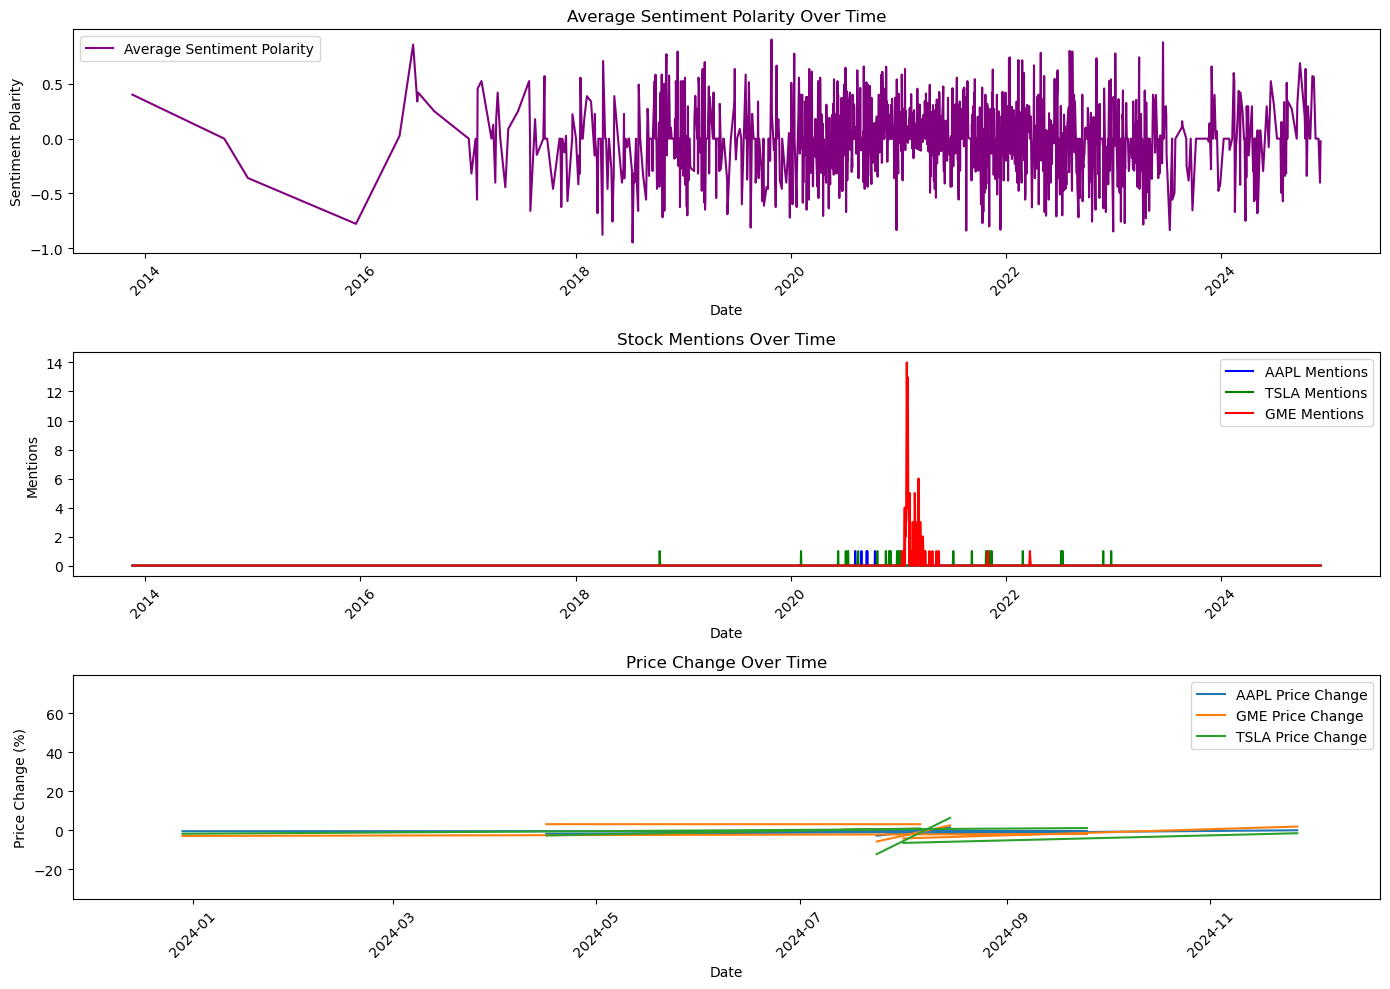

Visualization completed.


In [91]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch historical stock price data for specific stocks (e.g., AAPL, GME, TSLA)
tickers = ['AAPL', 'GME', 'TSLA', 'PLTR', 'AMD', 'NVDA', 'AMC', 'SOFI']
stock_data = {}

# Get stock price data for the past 1 year (or adjust the period)
for ticker in tickers:
    stock_data[ticker] = yf.download(ticker, period='1y')

# Convert each ticker's data to a DataFrame and calculate daily % price change
for ticker in tickers:
    stock_data[ticker]['Price_Change_' + ticker] = stock_data[ticker]['Adj Close'].pct_change() * 100  # Calculate percentage price change
    stock_data[ticker].reset_index(inplace=True)  # Reset index to make 'Date' a column

# Convert the 'Date' column in the stock data to datetime format (if not already)
for ticker in tickers:
    stock_data[ticker]['Date'] = pd.to_datetime(stock_data[ticker]['Date'])

# Ensure the 'Created' column in Reddit data is in datetime format
df['Created'] = pd.to_datetime(df['Created'], errors='coerce')
df['Date'] = df['Created'].dt.date  # Extract the date part as a 'date' object

# Convert the Reddit 'Date' column to datetime to match the stock data format
df['Date'] = pd.to_datetime(df['Date'])

# Convert each ticker's stock data to a single-level DataFrame and ensure 'Date' is a proper column
for ticker in tickers:
    stock_data[ticker] = stock_data[ticker].reset_index()  # Reset index to make 'Date' a column
    stock_data[ticker].columns = stock_data[ticker].columns.get_level_values(0)  # Flatten multi-level columns
    stock_data[ticker]['Date'] = pd.to_datetime(stock_data[ticker]['Date'])  # Ensure 'Date' is in datetime format

# Convert Reddit 'Date' column to datetime format
df['Created'] = pd.to_datetime(df['Created'], errors='coerce')  # Ensure 'Created' is in datetime format
df['Date'] = df['Created'].dt.date  # Extract date part
df['Date'] = pd.to_datetime(df['Date'])  # Convert back to datetime

# Merge stock price data with Reddit sentiment data
for ticker in tickers:
    df = pd.merge(df, stock_data[ticker][['Date', 'Price_Change_' + ticker]], on='Date', how='left')

# Resample sentiment data to daily averages
daily_sentiment = df.groupby('Date').agg({
    'Sentiment_Polarity': 'mean',  # Average sentiment per day
    'AAPL_Mentions': 'sum',        # Total mentions for AAPL
    'TSLA_Mentions': 'sum',        # Total mentions for TSLA
    'GME_Mentions': 'sum',         # Total mentions for GME
}).reset_index()

# Set the figure size for the plots
plt.figure(figsize=(14, 10))

# Plot average sentiment polarity over time
plt.subplot(3, 1, 1)
plt.plot(daily_sentiment['Date'], daily_sentiment['Sentiment_Polarity'], color='purple', label='Average Sentiment Polarity')
plt.title('Average Sentiment Polarity Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.legend()

# Plot stock mentions for AAPL, TSLA, GME over time
plt.subplot(3, 1, 2)
plt.plot(daily_sentiment['Date'], daily_sentiment['AAPL_Mentions'], color='blue', label='AAPL Mentions')
plt.plot(daily_sentiment['Date'], daily_sentiment['TSLA_Mentions'], color='green', label='TSLA Mentions')
plt.plot(daily_sentiment['Date'], daily_sentiment['GME_Mentions'], color='red', label='GME Mentions')
plt.title('Stock Mentions Over Time')
plt.xlabel('Date')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.legend()

# Plot price change for each stock over time (e.g., AAPL, TSLA, GME)
plt.subplot(3, 1, 3)
for ticker in tickers[:3]:  # Plotting just the first 3 tickers for clarity
    plt.plot(df['Date'], df['Price_Change_' + ticker], label=f'{ticker} Price Change')

plt.title('Price Change Over Time')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

print("Visualization completed.")

## CORRELATION B/W SENTIMENT AND STOCK PRICE MOVEMENTS

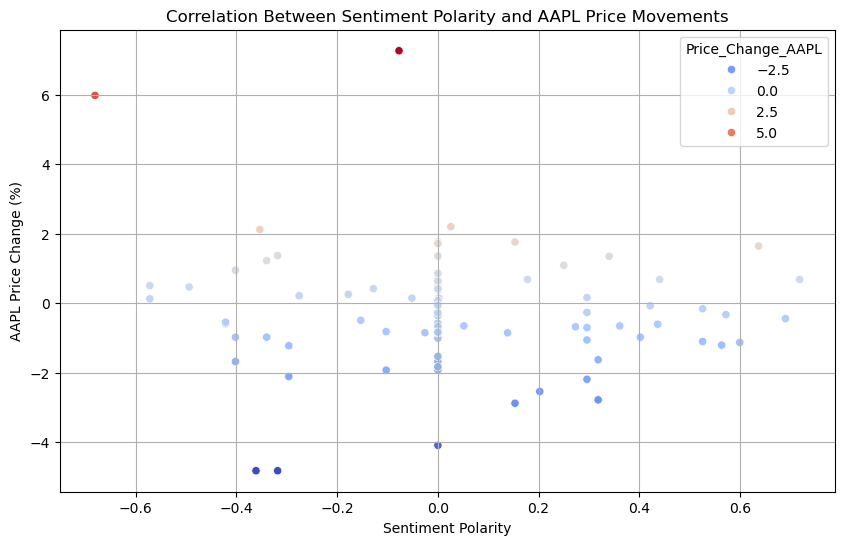

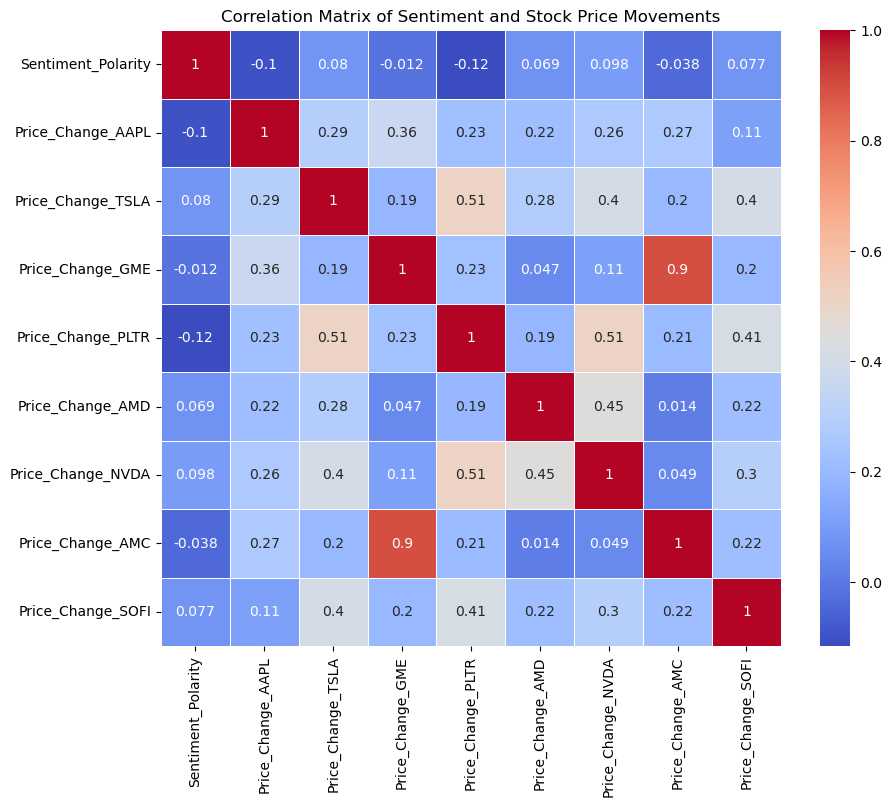

In [96]:
import seaborn as sns

### 2. Plot Correlation Between Sentiment Polarity and Stock Price Movements

# For scatterplot, let's use AAPL as an example (repeat for other stocks)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Sentiment_Polarity'], y=df['Price_Change_AAPL'], hue=df['Price_Change_AAPL'], palette='coolwarm')
plt.title('Correlation Between Sentiment Polarity and AAPL Price Movements')
plt.xlabel('Sentiment Polarity')
plt.ylabel('AAPL Price Change (%)')
plt.grid(True)
plt.show()

### 3. Heatmap of Correlations Between Sentiment and Price Movements for Multiple Stocks

# Calculate the correlation matrix
correlation_matrix = df[['Sentiment_Polarity', 'Price_Change_AAPL', 'Price_Change_TSLA', 'Price_Change_GME',
                         'Price_Change_PLTR', 'Price_Change_AMD', 'Price_Change_NVDA', 'Price_Change_AMC',
                         'Price_Change_SOFI']].corr()

# Plot a heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Sentiment and Stock Price Movements')
plt.show()

## Recommendations Based on Analysis:
**Actionable Insights:**

**1: Tesla (TSLA):**
Insight: Tesla’s stock price is strongly influenced by social media sentiment. Positive discussions, particularly around product launches or company developments, tend to push the stock upward. Conversely, negative sentiment often results in sharp declines.
Recommendation: Investors can monitor spikes in positive sentiment as potential buying opportunities. Conversely, caution should be exercised or positions reevaluated during periods of negative sentiment, especially when linked to regulatory concerns or executive decisions.

**2: GameStop (GME) & AMC Entertainment (AMC):**
Insight: These highly volatile "meme stocks" are significantly driven by online sentiment. Sharp increases in positive mentions often coincide with rapid price surges. However, this is counterbalanced by the potential for steep declines when sentiment shifts negatively.
Recommendation: Traders should use social media sentiment as a short-term indicator for these stocks. Sudden drops in sentiment may signal the right moment to sell, while surges in positive mentions could indicate opportunities for short-term gains. However, the high volatility warrants extra caution.

**3: Apple (AAPL):**
Insight: Apple’s stock price is less sensitive to social media sentiment and displays modest responses. Negative sentiment, particularly following underwhelming earnings reports or product delays, tends to lead to small price dips.
Recommendation: Investors should watch for negative sentiment following major announcements as a signal to reassess their positions. However, decisions should primarily rely on fundamental analysis rather than sentiment trends.

### Future Enhancements to Analysis:

**Incorporate Multiple Data Sources:**
Recommendation: Combine sentiment analysis with insights from news articles, financial reports, and earnings data. Including information from sources like analyst ratings or economic trends could provide a holistic understanding of stock price drivers.

**Adopt Advanced Sentiment Analysis Models:**
Recommendation: Utilize advanced Natural Language Processing (NLP) tools, such as BERT or GPT-based models, to capture more nuanced interpretations of social media discussions. These methods can better detect subtle shifts in sentiment.

**Implement Real-Time Sentiment Tracking:**
Recommendation: Develop a system to monitor sentiment in real-time across platforms like Reddit and Twitter. This would help investors respond promptly to emerging trends or market events.

**Integrate Volume and Volatility Metrics:**
Recommendation: Include trading volume and stock volatility data in future analyses. This would provide a clearer understanding of how attention and sentiment translate to actual price movements.

**Expand Sector-Level Analysis:**
Recommendation: Broaden sentiment analysis to evaluate discussions across entire sectors. This could help identify trends that impact multiple stocks or industries simultaneously.

# Buy/Sell Signals Derived from Social Media Sentiment:
**1: GameStop (GME):**

Buy Signal: A spike in positive sentiment and mentions has historically preceded short-term price increases. Investors may consider these trends as potential buying opportunities.
Sell Signal: A decline in sentiment often signals a price drop. Monitoring this trend can help traders exit positions before significant losses.

**2: AMC Entertainment (AMC):**

Buy Signal: Similar to GME, AMC tends to respond strongly to spikes in positive sentiment. Investors can leverage these surges as buy indicators.
Sell Signal: Declining sentiment correlates with rapid price decreases, making it a prudent time to sell.

**3: Tesla (TSLA):**

Mixed Signals: While Tesla shows some sensitivity to sentiment, it is not as pronounced as GME or AMC. Traders should corroborate sentiment trends with other indicators, such as earnings or technical analysis.

**4: Apple (AAPL):**

Low Sensitivity to Social Media: Apple’s stock price is only modestly affected by sentiment. Investors should base decisions primarily on fundamental analysis, such as company performance and broader market conditions.


## Conclusion:
GME and AMC show significant price volatility linked to social media sentiment. Positive sentiment on platforms like WallStreetBets can serve as buy signals, while negative sentiment can serve as sell signals.

TSLA and AAPL are less responsive to social media sentiment, and buy/sell decisions should be more grounded in traditional financial analysis rather than social media-driven sentiment. In summary, speculative stocks like GME and AMC are more sensitive to sentiment, making social media a valuable tool for predicting short-term price changes. However, larger, more established stocks like AAPL are less influenced by social media sentiment and should be traded with more traditional financial indicator

